# Estimating Canada's agricultural waste yield
Here, we estimate the waste yield at each location in Canada, using (non-spatial) agricultural yield data from Statistic Canada, and (spatial) crop type data from the Annual Crop Inventory dataset, which we created from the notebook `01_dataWrangling_1_cropProvince`.

The output of this notebook is a shapefile of Canada, with points at a 3km resolution. The shapefile shows, for each point in Canada, the agricultural waste type (categorized by aciCode) and amount of waste yield (in tonnes). 

In [1]:
import rasterio as rs
import numpy as np
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
from fuzzywuzzy import fuzz, process
pd.options.mode.chained_assignment = None  # default='warn'

## Reading data
This notebook uses the following data: 
* `aci` - dataframe showing classifications for the [Annual Crop Inventory of Canada](https://open.canada.ca/data/en/dataset/ba2645d5-4458-414d-b196-6303ac06c1c9). Each ACI code represents a type of landuse for agriculture, such as 'greenhouses', 'oats', 'too wet to be seeded', 'wheat'...etc.
* `gdf_aci` - geo dataframe showing the Annual Crop Inventory (ACI) code for each location in Canada
* `sc` - dataframe showing agricultural yield of Canada, categorized by agricultural commodity, such as 'barley', 'oats', 'peas'...etc. These commodity names are different from the ACI codes. <mark>For now, the estimated agricultural waste yield for all crop types is 10%. This needs to updated according to agricultural waste yield literature by Arjang </mark>

In [2]:
# read ACI codes
aci = pd.read_feather('data/aci/aci_classifications.feather')
aci.name = aci.name.str.lower().str.strip()
aci.code = aci.code.astype('str')

In [3]:
# read aci shapefile 
gdf_aci = gpd.read_file('data/shp/canada_aci.shp')
gdf_aci.aciCode = gdf_aci.aciCode.astype('str')
gdf_aci = gdf_aci[['aciCode', 'province', 'geometry']]

In [4]:
# read statscan data
sc = pd.read_feather('data/statsCan/all.feather')
sc = sc[(sc.unit == 'Metric tonnes') & (sc.year == 2021)]

# formatting commodity name and code columns statscan data
sc['commodityCode'] = sc.commodity.str.extract(r'(\[\d+\])')
sc.commodityCode = sc.commodityCode.str.strip('[]')
sc.commodity = sc.commodity.str.replace(r'Fresh ', '', regex=True) # remove 'fresh'
sc.commodity = sc.commodity.str.replace(r'\[\d+\]', '', regex=True) # remove commodity code
sc.commodity = sc.commodity.str.lower().str.strip()

# add estimated waste yield in statscan data 
sc['wasteYield_tonnes'] = sc.value * 0.1 # assuming all crops have waste yield of 10% - to be adjusted by Arjang
sc.wasteYield_tonnes.fillna(0, inplace=True)
sc = sc[['year', 'province', 'commodity', 'commodityCode', 'commodity_type', 'wasteYield_tonnes']]

# change province name to province codes
provinceCodes = {
    'Alberta': 'ab', 'British Columbia': 'bc', 'Manitoba': 'mb', 'New Brunswick': 'nb', 'Newfoundland and Labrador': 'nl', 
    'Nova Scotia': 'ns', 'Ontario': 'on', 'Prince Edward Island': 'pe', 'Quebec': 'qc', 'Saskatchewan': 'sk'
}
sc['provinceCode'] = sc.province.map(lambda x: provinceCodes[x])
sc.rename(columns={'province': 'provinceName', 'provinceCode': 'province'}, inplace=True)
sc = sc[['year', 'province', 'commodity', 'commodity_type', 'wasteYield_tonnes']]

## Estimating waste yield for each point in Canada
Here, we create a **dummy** dataframe that shows, for each point in Canada, the agricultural waste type (categorized by aciCode) and amount of waste yield (in tonnes). This is done through the following steps: 
* create dataframe `match` with two columns: `scName` and `aciCode`, which matches each commodity name in the statistics canada dataset (`scName`) to an ACI code (`aciCode`). For now, this is a dummy df, where aciCodes are roughly matched to statsCan commodity names using fuzzy wuzzy. <mark>Arjang will replace this dummy df </mark>
    * note that there are more stats can commodity codes than aci codes, which means that multiple statsCan codes could be matched to one aci code.
* create dataframe `scAci`, which adds an aciCode to each row in statsCan dataset on agricultural yield. 
* create dataframe `aciYieldPerPt`, which shows, for each crop type in each province, how many tonnes of agricultural waste could be produced per point on the map. 
    * in each province, for each crop type, this is done by taking the total amount of agricultural waste from the statsCan dataset, and dividing this number by the total number of points for that crop type in that province. 
* create geodataframe `gdf` which shows, for each point in Canada, the agricultural waste type (categorized by aciCode) and amount of waste yield (in tonnes). Save as `data/shp/canada_wasteYield.shp`

In [5]:
# match each scName to an aciName 
match = pd.DataFrame(sc.commodity.unique())
match.rename(columns={0: 'scName'}, inplace=True)
choices = list(aci.name.unique())
match['aciName'] = match.scName.map(lambda x: process.extractOne(x, choices)[0])
match = pd.merge(match, aci.rename(columns={'name': 'aciName', 'code': 'aciCode'}), how='left', on='aciName')
match.head(3)

,scName,aciName,aciCode
0,barley,barley,133
1,"beans, all dry (white and coloured)",beans,167
2,canola (rapeseed),canola/rapeseed,153


In [6]:
%%time
# estimate agricultural yield per location, for each crop type in each province.
scAci = pd.merge(sc, match, how='left', left_on='commodity', right_on='scName')
scAci = scAci[['year', 'province', 'scName', 'aciCode', 'wasteYield_tonnes']]
def calcYieldPerPt(row): 
    # find number of points for that province and aciCode in gdf_aci 
    prov = row.province
    aciCode = row.aciCode 
    nPts = len(gdf_aci[(gdf_aci.aciCode == aciCode) & (gdf_aci.province == prov)])
    
    # calculate total waste yield / n points, to find waste yield per pt
    yieldTot = row.wasteYield_tonnes
    yieldPerPt = 0 if nPts == 0 else yieldTot / nPts 
    
    return yieldPerPt 
scAci['yieldPerPt'] = scAci.apply(lambda row: calcYieldPerPt(row), axis=1)

CPU times: total: 3.95 s
Wall time: 4.14 s


In [7]:
# make df showing yieldPerPt for each aciCode in each province 
aciYieldPerPt = scAci.groupby(['year', 'province', 'aciCode']).sum().yieldPerPt.reset_index()
aciYieldPerPt = pd.merge(aciYieldPerPt, aci.rename(columns={'code': 'aciCode'}), how='left', on='aciCode')

In [9]:
# match waste yield to each pt in gdf 
gdf = pd.merge(gdf_aci, aciYieldPerPt, how='left', on=['province', 'aciCode'])
matchList = match.groupby(['aciCode', 'aciName'])['scName'].apply(tuple).reset_index()
gdf = pd.merge(gdf, matchList[['aciCode', 'scName']], how='left', on='aciCode')
gdf.rename(columns={'yieldPerPt': 'waste_t', 'name': 'aciName'}, inplace=True)
gdf = gdf[['province', 'aciCode', 'aciName', 'scName', 'waste_t', 'geometry']]

# remove unmatched points 
before = len(gdf)
gdf = gdf[~gdf.waste_t.isna()]
after = len(gdf)
perc = (before-after) / before * 100
print('removed unmatched points ({}%)'.format(round(perc)))

# format list of scNames to save shpfile
def unListScName(x): 
    s = ''
    for i, word in enumerate(x): 
        if i == len(x)-1: 
            s = s + word
            break
        s = s + word + ','
    return s
gdf.scName = gdf.scName.map(lambda x: unListScName(x))

# display
print(gdf.shape)
gdf.head()

removed unmatched points (4%)
(30342, 6)


,province,aciCode,aciName,scName,waste_t,geometry
0,ab,122,pasture/forages,asparagus,0.001079,POINT (-1222801.843 2246057.985)
1,ab,136,oats,"oats,apricots,currants,brussels sprouts,french...",309.996178,POINT (-1222801.843 2243052.597)
2,ab,136,oats,"oats,apricots,currants,brussels sprouts,french...",309.996178,POINT (-1219795.106 2240047.209)
3,ab,122,pasture/forages,asparagus,0.001079,POINT (-1219795.106 2237041.820)
4,ab,136,oats,"oats,apricots,currants,brussels sprouts,french...",309.996178,POINT (-1216788.369 2237041.820)


## Format, save, and visualise resulting geodataframe

In [10]:
# save gdf 
gdf.to_file('data/shp/canada_wasteYield.shp')

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [11]:
gdf.head()

,province,aciCode,aciName,scName,waste_t,geometry
0,ab,122,pasture/forages,asparagus,0.001079,POINT (-1222801.843 2246057.985)
1,ab,136,oats,"oats,apricots,currants,brussels sprouts,french...",309.996178,POINT (-1222801.843 2243052.597)
2,ab,136,oats,"oats,apricots,currants,brussels sprouts,french...",309.996178,POINT (-1219795.106 2240047.209)
3,ab,122,pasture/forages,asparagus,0.001079,POINT (-1219795.106 2237041.820)
4,ab,136,oats,"oats,apricots,currants,brussels sprouts,french...",309.996178,POINT (-1216788.369 2237041.820)


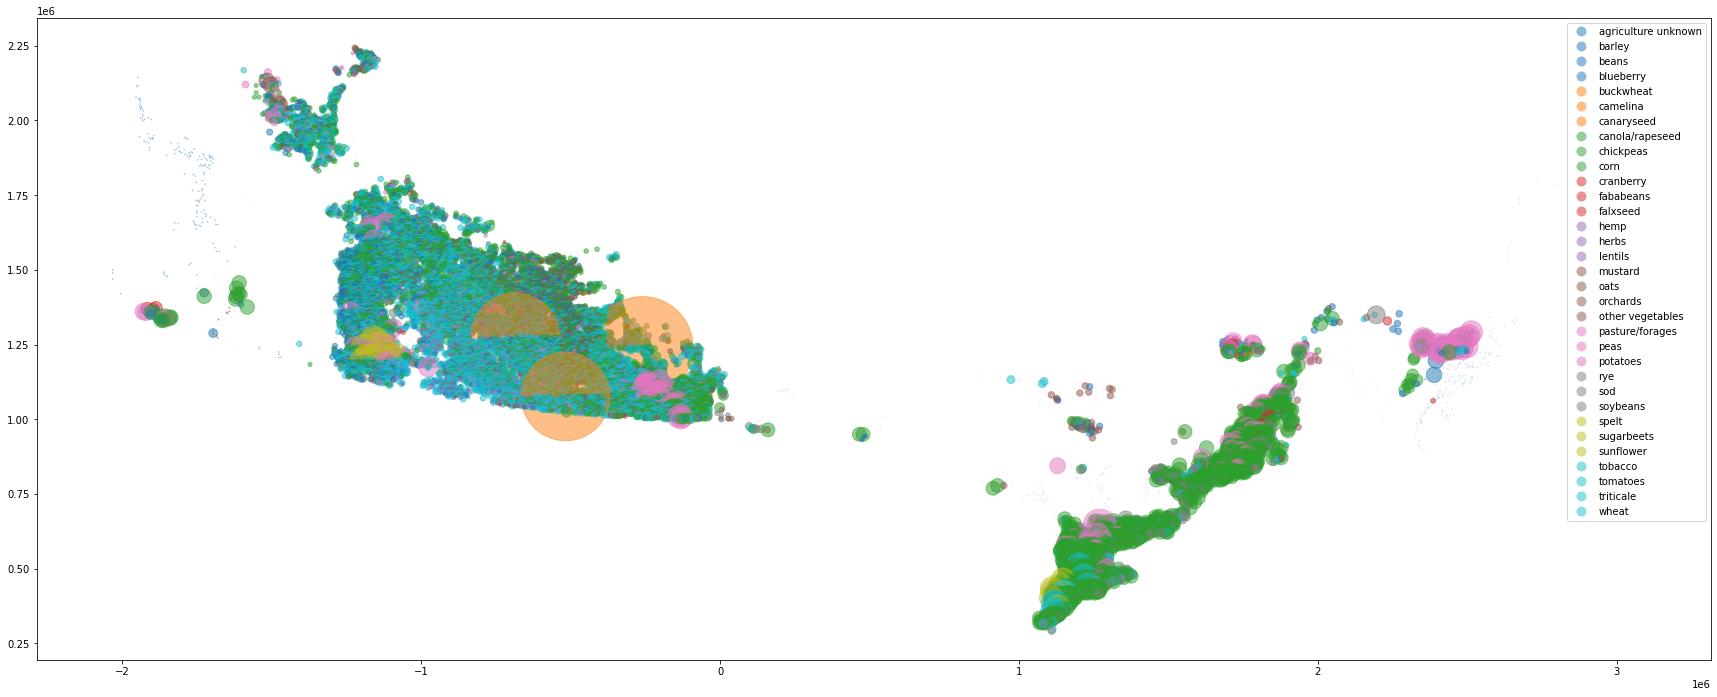

CPU times: total: 3.38 s
Wall time: 3.38 s


In [12]:
%%time
fig, ax = plt.subplots(1,1,figsize=(30,30))
gdf.plot(column='aciName', markersize=gdf.waste_t / 10, ax=ax, alpha=0.5, legend=True)
plt.show()

## Limitations and further work
Limitations 
* In order to estimate the amount of waste that will be available at each location in Canada, we need data on the average 'waste yield' for each type of crop (e.g. on average, 5% of apples in apple orchard is wasted). Currently, a dummy value is used - 10%. This is done in the code `sc['wasteYield_tonnes'] = sc.value * 0.1`, under the section 'reading data'. 
* In order to estimate waste yield for each location in Canada, the Statistics Canada (agricultural) commodity names need to be matched with the Annual Crop Inventory (aci) code names. Currently, this is matched very roughly using the python module fuzzy wuzzy, leading to inaccurate results (e.g. 'apples' was matched with 'peas'). See section 'estimating waste yield for each point in Canada'. 
    * This inaccurate matching leads to very strange results. 

Further work (<mark>**essential**</mark> for generating meaningful results)
* Estimate the waste yield of different crop types according to literature. With this information, the waste yield can either be estimated with the statistics canada dataframe `sc`, or in the final geodataframe `gdf`. 
* Match Statistics Canada commodity names with ACI codes by creating dataframe with two columns `scName` and `aciName`. Use this dataframe to replace the current dataframe `match`, under the section 'estimating waste yield for each point in Canada'. 

Without accurate data for agricultural waste yield and accurate matching of statsCan commodity codes and aci codes, the spatial analysis results are meaningless. **It is therefore very important not to see the spatial analysis results as insights for the company, until the two problems of estimating agricultural waste yield and matching sc and aci codes are solved.**